In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from graphviz import pipe_lines
from mlflow import catboost
from pandas.core.common import random_state
from scipy.constants import precision
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Binarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pd.options.display.max_columns = None
sklearn.set_config(transform_output='pandas')
from sklearn.metrics import average_precision_score
import mlflow

mlflow.set_registry_uri('./mlruns')
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor





In [3]:
df = pd.read_csv('data/Student_Performance.csv')

In [4]:
df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


In [5]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [6]:
df["Performance Index"].mean()

55.2248

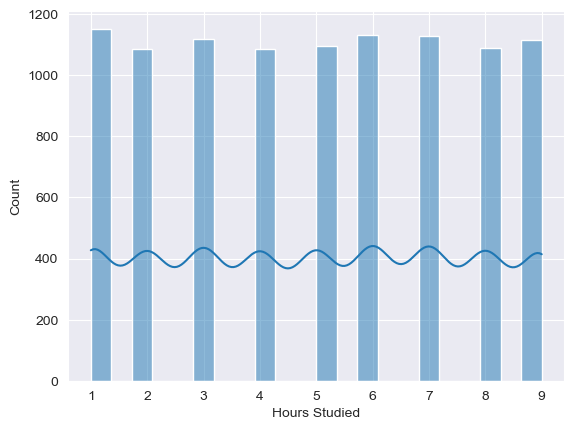

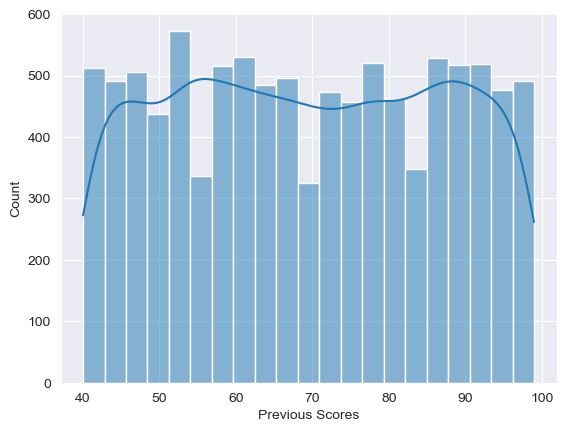

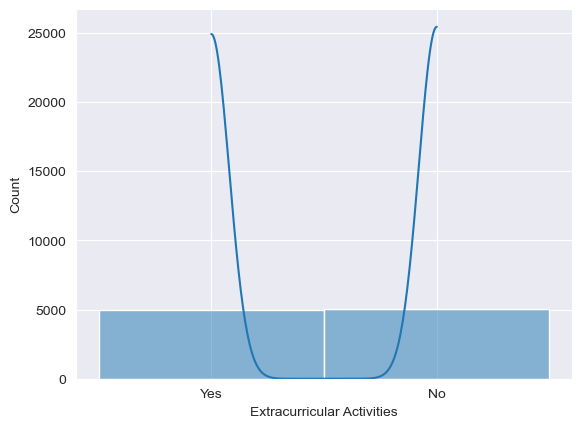

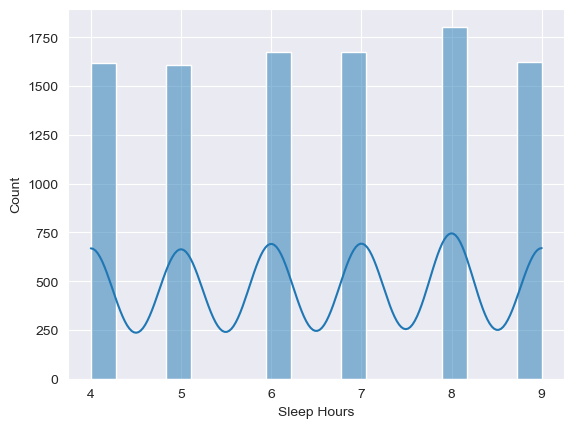

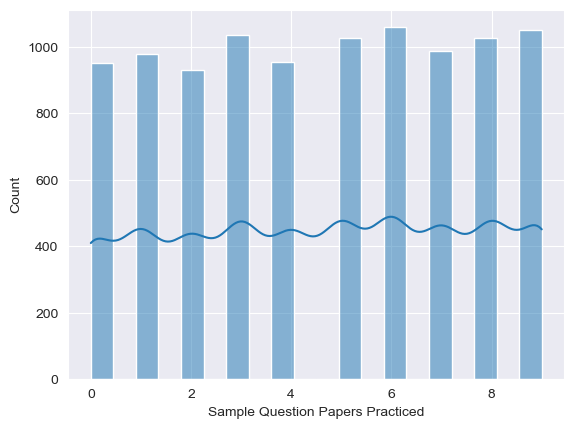

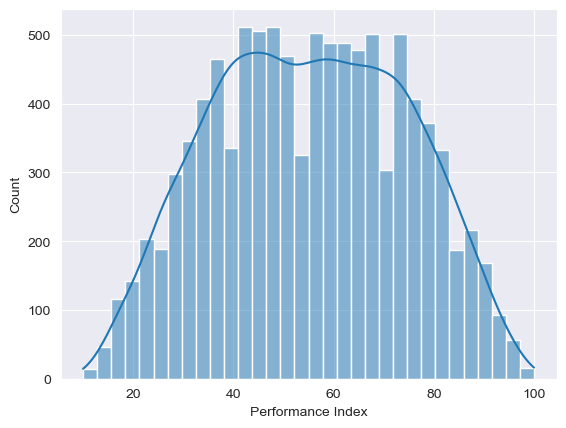

In [7]:
for col in df.columns:
    sns.histplot(data = df, x=col, kde=30)
    plt.show()

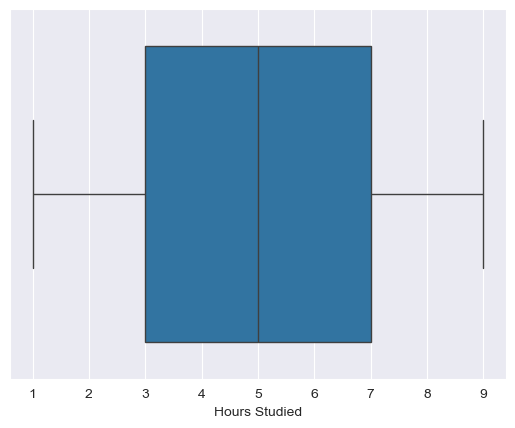

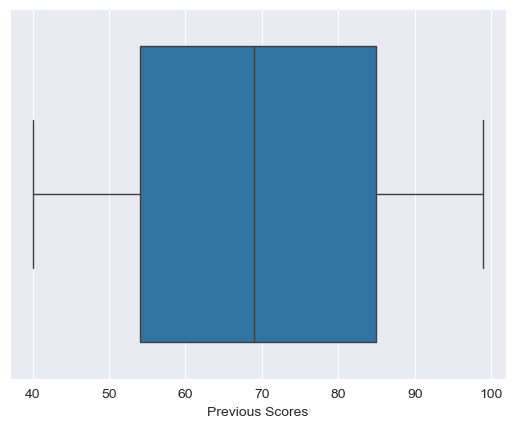

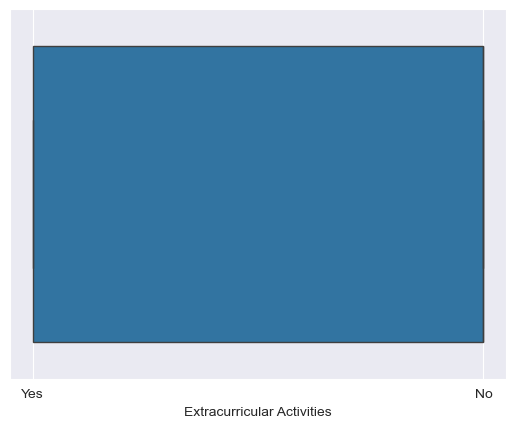

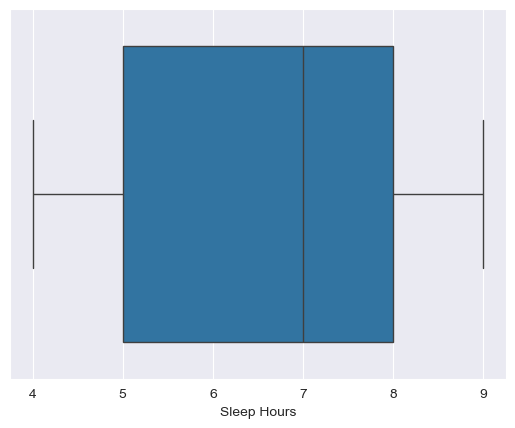

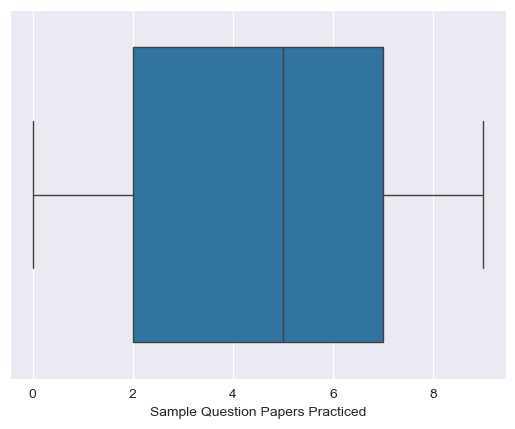

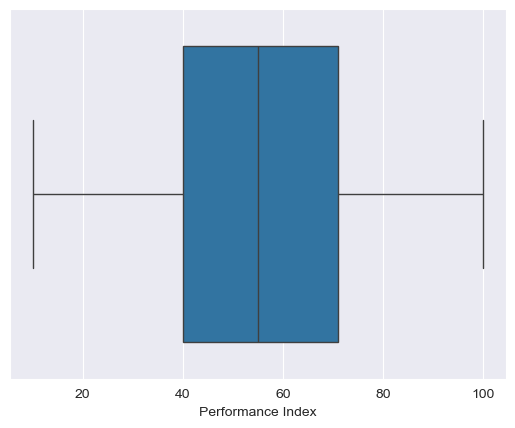

In [8]:
for col in df.columns:
    sns.boxplot(data = df, x=col)
    plt.show()

In [9]:
df.dtypes

Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities           object
Sleep Hours                           int64
Sample Question Papers Practiced      int64
Performance Index                   float64
dtype: object

In [10]:
df['Extracurricular Activities'].value_counts()

Extracurricular Activities
No     5052
Yes    4948
Name: count, dtype: int64

In [11]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")  # Ensure dense output
encoder.fit(df[['Extracurricular Activities']])
encoded_array = encoder.transform(df[['Extracurricular Activities']])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Extracurricular Activities']))
df_final = pd.concat([df.drop(columns=['Extracurricular Activities']), encoded_df], axis=1)

print(df_final.head())

   Hours Studied  Previous Scores  Sleep Hours  \
0              7               99            9   
1              4               82            4   
2              8               51            7   
3              5               52            5   
4              7               75            8   

   Sample Question Papers Practiced  Performance Index  \
0                                 1               91.0   
1                                 2               65.0   
2                                 2               45.0   
3                                 2               36.0   
4                                 5               66.0   

   Extracurricular Activities_Yes  
0                             1.0  
1                             0.0  
2                             1.0  
3                             1.0  
4                             0.0  


In [33]:
df_final.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index,Extracurricular Activities_Yes
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800,0.494800
std,2.589309,17.343152,1.695863,2.867348,19.212558,0.499998
min,1.000000,40.000000,4.000000,0.000000,10.000000,0.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000,0.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000,0.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000,1.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000,1.000000


In [35]:
X = df_final.drop(columns = ['Performance Index'])
y = df_final['Performance Index']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
X_train

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Extracurricular Activities_Yes
9254,5,49,7,5,0.0
1561,2,48,7,6,1.0
1670,2,81,7,2,0.0
6087,2,46,6,1,0.0
6669,8,47,9,0,0.0
...,...,...,...,...,...
5734,8,50,6,6,1.0
5191,4,68,9,3,0.0
5390,9,48,7,6,0.0
860,1,47,9,0,0.0


In [39]:
X_test

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Extracurricular Activities_Yes
6252,5,69,8,2,0.0
4684,2,46,4,8,1.0
1731,7,56,7,5,1.0
4742,6,42,8,5,1.0
4521,7,53,4,6,0.0
...,...,...,...,...,...
6412,2,70,7,3,0.0
8285,4,79,9,3,0.0
7853,2,40,7,2,1.0
1095,3,83,7,5,0.0


In [40]:
y_test

6252    51.0
4684    20.0
1731    46.0
4742    28.0
4521    41.0
        ... 
6412    45.0
8285    66.0
7853    16.0
1095    65.0
6929    47.0
Name: Performance Index, Length: 2000, dtype: float64

In [41]:
y_train

9254    36.0
1561    25.0
1670    59.0
6087    22.0
6669    40.0
        ... 
5734    48.0
5191    51.0
5390    44.0
860     20.0
7270    24.0
Name: Performance Index, Length: 8000, dtype: float64

In [19]:
X_train.select_dtypes(exclude='object')

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Extracurricular Activities_Yes
9254,5,49,7,5,0.0
1561,2,48,7,6,1.0
1670,2,81,7,2,0.0
6087,2,46,6,1,0.0
6669,8,47,9,0,0.0
...,...,...,...,...,...
5734,8,50,6,6,1.0
5191,4,68,9,3,0.0
5390,9,48,7,6,0.0
860,1,47,9,0,0.0


In [43]:
num_cols = X_train.select_dtypes(exclude='object').columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

In [44]:
num_cols

['Hours Studied',
 'Previous Scores',
 'Sleep Hours',
 'Sample Question Papers Practiced',
 'Extracurricular Activities_Yes']

In [45]:
cat_cols

[]

In [55]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('power_transformer', PowerTransformer())
])  
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))
])
 # Preprocessor that applies transformations to numerical & categorical columns
 
 
main_pipe_ct = Pipeline([
    ("preprocessor", ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])),
     
    ("cat", CatBoostRegressor(iterations=500, verbose=100))
])
 
main_pipe_ct.fit(X_train, y_train)
y_pred = main_pipe_ct.predict(X_test)

main_pipe_dt = Pipeline([
    ("preprocessor", ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])),

    ("dt", DecisionTreeRegressor(max_depth=6, random_state=42))
])

main_pipe_dt.fit(X_train, y_train)
y_pred = main_pipe_dt.predict(X_test)


main_pipe_rf = Pipeline([
    ("preprocessor", ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])),

    ("rf", RandomForestRegressor(n_estimators=200, random_state=42))
])

main_pipe_rf.fit(X_train, y_train)
y_pred = main_pipe_rf.predict(X_test)


     

Learning rate set to 0.099909
0:	learn: 17.4907006	total: 2.01ms	remaining: 1s
100:	learn: 2.0275234	total: 218ms	remaining: 859ms
200:	learn: 1.9643110	total: 474ms	remaining: 705ms
300:	learn: 1.9164923	total: 689ms	remaining: 456ms
400:	learn: 1.8755687	total: 889ms	remaining: 219ms
499:	learn: 1.8392282	total: 1.05s	remaining: 0us


In [56]:
def objective(trial):
    depth = trial.suggest_int("max_depth", 1, 10)
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    ccp_alpha = trial.suggest_float("ccp_alpha", 0, 1)
   
    max_samples = trial.suggest_float("max_samples", 0.1, 1)
    #max_features = trial.suggest_float("max_features", 0.1, 1)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    
    main_pipe_rf = Pipeline([
        ("preprocessor", ColumnTransformer([
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols)
        ])),

        ("rf", RandomForestRegressor(n_estimators=n_estimators, max_depth=depth, random_state=42, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_samples=max_samples, ccp_alpha=ccp_alpha))
    ])
    
    
    
    main_pipe_rf.fit(X_train, y_train)
    

    pred_rf = main_pipe_rf.predict(X_test)
    
    mse = mean_squared_error(y_test,  pred_rf)
    
    return mse

In [57]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-03-09 19:39:14,419] A new study created in memory with name: no-name-538d22df-d7dc-49bd-af81-6aa33c28a321
[I 2025-03-09 19:39:16,303] Trial 0 finished with value: 7.774631222676105 and parameters: {'max_depth': 6, 'n_estimators': 313, 'ccp_alpha': 0.32659987169202487, 'max_samples': 0.2854377882817778, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 7.774631222676105.
[I 2025-03-09 19:39:16,942] Trial 1 finished with value: 73.11052873561742 and parameters: {'max_depth': 2, 'n_estimators': 187, 'ccp_alpha': 0.6500715239850815, 'max_samples': 0.9066252190550225, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 7.774631222676105.
[I 2025-03-09 19:39:17,842] Trial 2 finished with value: 72.45009588033834 and parameters: {'max_depth': 2, 'n_estimators': 289, 'ccp_alpha': 0.8040832026612901, 'max_samples': 0.570610548591119, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: 7.774631222676105.
[I 2025-0

In [26]:
study.best_params

{'max_depth': 10,
 'n_estimators': 500,
 'ccp_alpha': 0.0007610162300795238,
 'max_samples': 0.47182001163319753,
 'min_samples_split': 10,
 'min_samples_leaf': 4}

In [58]:
main_pipe_rf = Pipeline([
    ("preprocessor", ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])),

    ("rf", RandomForestRegressor(**study.best_params, random_state=42))
])
main_pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transformer',
                                                                   PowerTransformer())]),
                                                  ['Hours Studied',
                                                   'Previous Scores',
                                                   'Sleep Hours',
                                                   'Sample Question Papers '
                                                   'Practiced',
                                                   'Extracurricular '
                                                   'Activities_Yes']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [])])),
                ('rf',
                 RandomForestRegressor(ccp_alpha=0.0004949607619455661,
                                       max_depth=10,
                                       max_samples=0.9076351956469714,
                                       min_samples_leaf=8, min_samples_split=5,
                                       n_estimators=179, random_state=42))])

In [59]:
y_pred

array([56.19      , 22.17666667, 46.325     , ..., 15.8975    ,
       62.85675   , 45.35666667])

In [61]:
dt_mse = mean_squared_error(y_test, dt_preds)
dt_rmse = mean_squared_error(y_test, dt_preds, squared=False)
dt_mae = mean_absolute_error(y_test, dt_preds)
dt_r2 = r2_score(y_test, dt_preds)

print(f"Decision Tree MSE: {dt_mse:.4f}")
print(f"Decision Tree RMSE: {dt_rmse:.4f}")
print(f"Decision Tree MAE: {dt_mae:.4f}")
print(f"Decision Tree R² Score: {dt_r2:.4f}")

NameError: name 'dt_preds' is not defined

In [50]:
rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

print(f"Random Forest MSE: {rf_mse:.4f}")
print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"Random Forest MAE: {rf_mae:.4f}")
print(f"Random Forest R² Score: {rf_r2:.4f}")

Random Forest MSE: 5.1346
Random Forest RMSE: 2.2660
Random Forest MAE: 1.8105
Random Forest R² Score: 0.9861


In [51]:
cat_mse = mean_squared_error(y_test, cat_preds)
cat_rmse = mean_squared_error(y_test, cat_preds, squared=False)
cat_mae = mean_absolute_error(y_test, cat_preds)
rf_r2 = r2_score(y_test, cat_preds)

print(f"CatBoost MSE: {cat_mse:.4f}")
print(f"CatBoost RMSE: {cat_rmse:.4f}")
print(f"CatBoost MAE: {cat_mae:.4f}")
print(f"CatBoost R² Score: {rf_r2:.4f}")

CatBoost MSE: 4.3133
CatBoost RMSE: 2.0769
CatBoost MAE: 1.6631
CatBoost R² Score: 0.9884


In [52]:
residuals = y_test - dt_preds  # Errors

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--', label="Zero Error")
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Plot (Decision Tree)")
plt.legend()
plt.show()


NameError: name 'dt_preds' is not defined

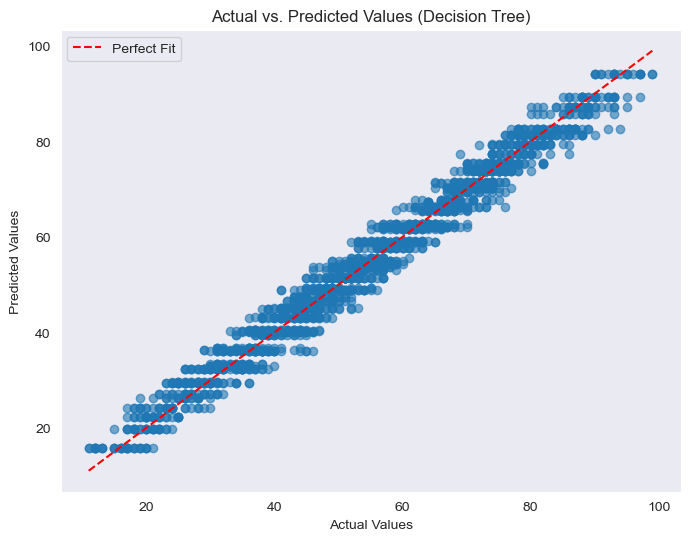

In [53]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, dt_preds, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Decision Tree)")
plt.legend()
plt.grid()
plt.show()


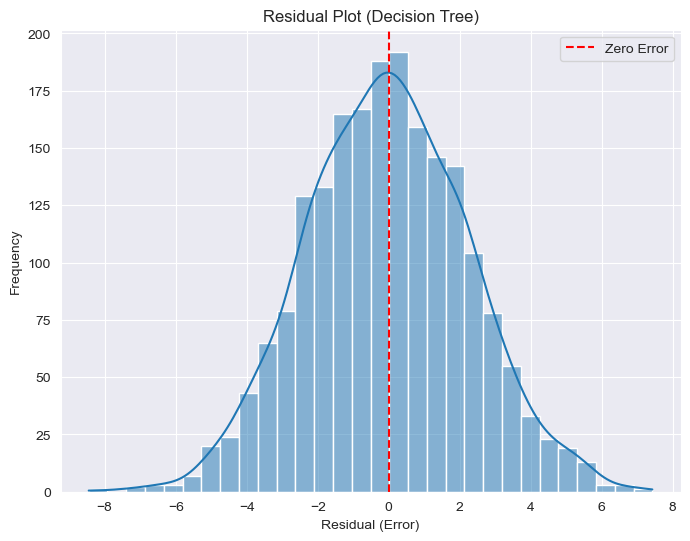

In [54]:

residuals = y_test - rf_preds  # Errors

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--', label="Zero Error")
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Plot (Decision Tree)")
plt.legend()
plt.show()


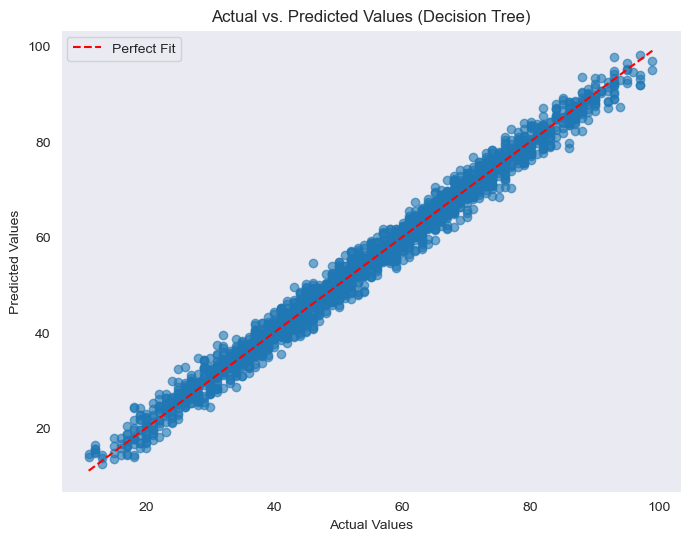

In [55]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, rf_preds, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Decision Tree)")
plt.legend()
plt.grid()
plt.show()

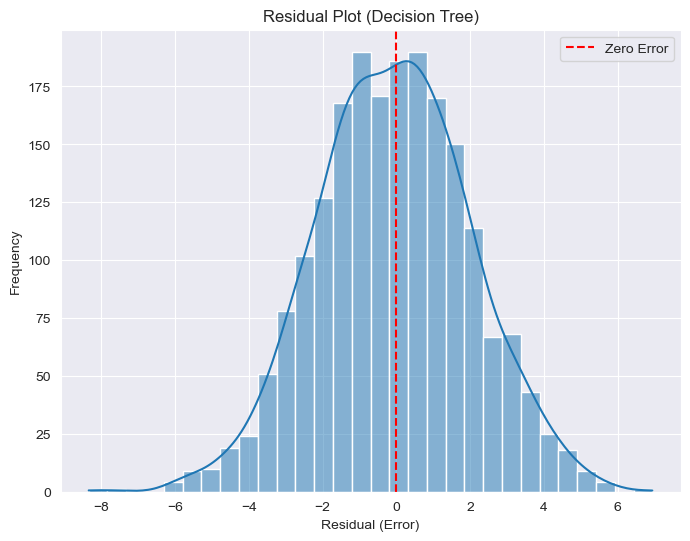

In [56]:
residuals = y_test - cat_preds  # Errors

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--', label="Zero Error")
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Plot (Decision Tree)")
plt.legend()
plt.show()

In [53]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, cat_preds, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Decision Tree)")
plt.legend()
plt.grid()
plt.show()

NameError: name 'cat_preds' is not defined

<Figure size 800x600 with 0 Axes>

In [58]:
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    importance_df = pd.DataFrame(importance, index=feature_names, columns=["Importance"])
    importance_df = importance_df.sort_values(by="Importance", ascending=False)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=importance_df["Importance"], y=importance_df.index)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.show()

Mean Squared Error (MSE): 4.8347
Root Mean Squared Error (RMSE): 2.1988
Mean Absolute Error (MAE): 1.7538
R² Score: 0.9870
Mean Absolute Percentage Error (MAPE): 3.83%
Median Absolute Error: 1.4675
Mean Absolute Error: 1.7538


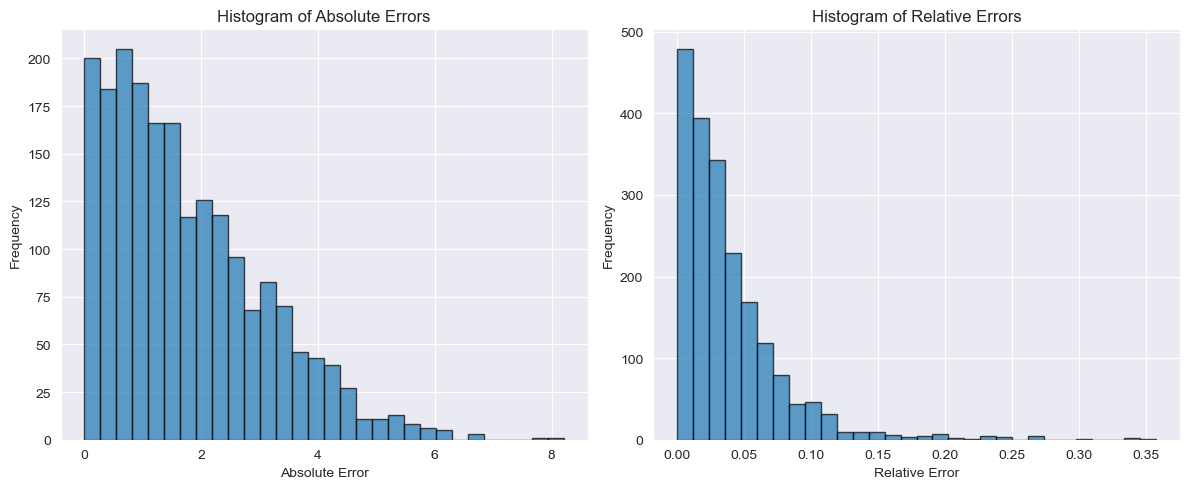

In [59]:
mse = mean_squared_error(y_test, y_pred) # Calculate Evaluation Metrics
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Errors
absolute_errors = np.abs(y_test - y_pred)
relative_errors = absolute_errors / np.abs(y_test)  # Relative error (percentage form)
differences = y_test - y_pred  # Differences between true and predicted

# Median and Mean of Errors
median_abs_error = np.median(absolute_errors)
mean_abs_error = np.mean(absolute_errors)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Median Absolute Error: {median_abs_error:.4f}")
print(f"Mean Absolute Error: {mean_abs_error:.4f}")

# Plot Histogram of Absolute Errors
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(absolute_errors, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Histogram of Absolute Errors")

# Plot Histogram of Relative Errors
plt.subplot(1, 2, 2)
plt.hist(relative_errors, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Relative Error")
plt.ylabel("Frequency")
plt.title("Histogram of Relative Errors")

plt.tight_layout()
plt.show()


In [60]:
mape

3.830500637125194

In [61]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
accuracy_score(y_test, y_pred)

0.136

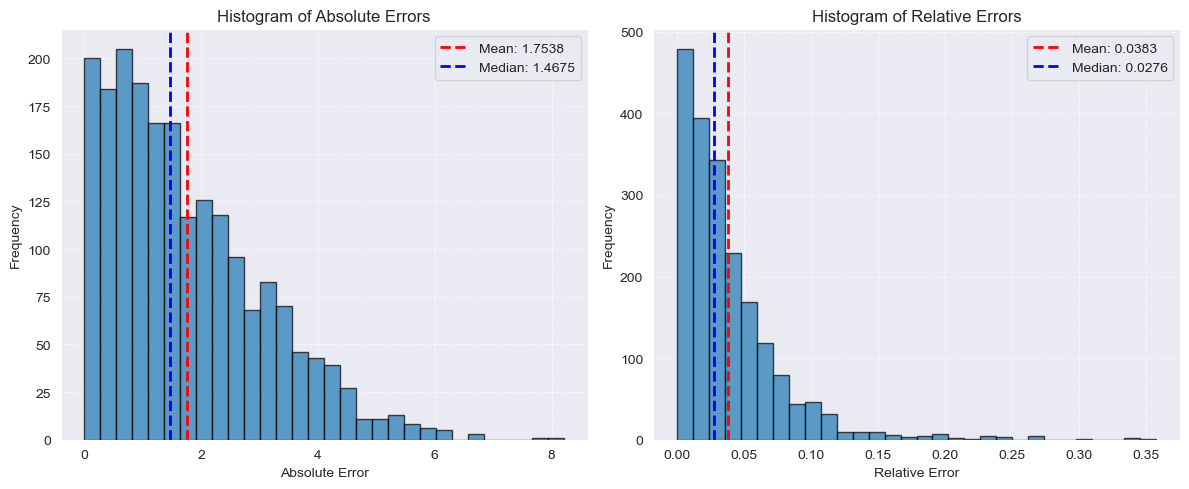

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
mean_abs_error = np.mean(absolute_errors)
median_abs_error = np.median(absolute_errors)

mean_rel_error = np.mean(relative_errors)
median_rel_error = np.median(relative_errors)

plt.figure(figsize=(12, 5))

# Histogram of Absolute Errors
plt.subplot(1, 2, 1)
plt.hist(absolute_errors, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(mean_abs_error, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_abs_error:.4f}")
plt.axvline(median_abs_error, color='blue', linestyle='dashed', linewidth=2, label=f"Median: {median_abs_error:.4f}")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Histogram of Absolute Errors")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Histogram of Relative Errors
plt.subplot(1, 2, 2)
plt.hist(relative_errors, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(mean_rel_error, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_rel_error:.4f}")
plt.axvline(median_rel_error, color='blue', linestyle='dashed', linewidth=2, label=f"Median: {median_rel_error:.4f}")
plt.xlabel("Relative Error")
plt.ylabel("Frequency")
plt.title("Histogram of Relative Errors")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


<Axes: ylabel='Count'>

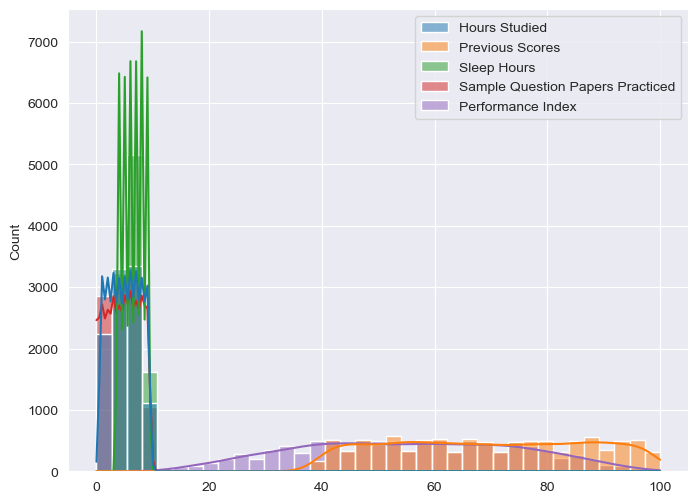

In [15]:
plt.figure(figsize=(8,6))
sns.histplot(df, kde=True)